In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
# from dance_evaluation import *
import matplotlib.pyplot as plt

def load_pickle(filepath):
    with open(filepath, "rb") as f:
        json_data = pickle.load(f)
    return json_data

def save_to_pickle(filepath, data):
    # filepath = os.path.join(savepath, filename)
    with open(filepath, "wb") as f:
        pickle.dump(data, f)

In [2]:

def load_data(dirPath, metric, a, b, w_sec, h_sec, n, mode):
    # Define body part keys (for the statistical data) and their filename prefix
    parts = {
        "left_hand": "left_hand",
        "right_hand": "right_hand",
        "left_foot": "left_foot",
        "right_foot": "right_foot",
        "both_hand": "both_hand",
        "both_foot": "both_foot"
    }

    # Load y-axis data
    df_y = {}
    for key, prefix in parts.items():
        file_y = os.path.join(dirPath, f"{prefix}_y_zero_uni_W{w_sec}_H{h_sec}_{a}_{b}.pkl")
        df_y[key] = pd.read_pickle(file_y)

    # Load x-axis data (assumes similar naming with '_x_' replacing '_y_')
    df_x = {}
    for key, prefix in parts.items():
        file_x = os.path.join(dirPath, f"{prefix}_x_zero_uni_W{w_sec}_H{h_sec}_{a}_{b}.pkl")
        df_x[key] = pd.read_pickle(file_x)

    # Extract BPM medians from y-axis DataFrames (using row index n)
    bpms_y = { key: df_y[key].iloc[n]["bpm_median"] for key in parts }
    
    # Extract BPM medians from x-axis DataFrames (using row index n)
    bpms_x = { key: df_x[key].iloc[n]["bpm_median"] for key in parts }
    
    # Extract common variables (taken from the left hand y-axis DataFrame)
    ref = df_y["left_hand"].iloc[n]["music_tempo"]
    filename = df_y["left_hand"].iloc[n]["filename"]

    # Define a mapping for body onsets file names:
    # For the y-axis, the left_hand corresponds to the file "left_wrist_{mode}_{filename}.pkl", etc.
    onset_mapping = {
        "left_hand": "left_wrist",
        "right_hand": "right_wrist",
        "left_foot": "left_ankle",
        "right_foot": "right_ankle"
    }
    onset_dir = f"./extracted_body_onsets/{metric}/"

    # Load body onset files for y-axis
    onsets_y = {}
    for key, label in onset_mapping.items():
        path_y = os.path.join(onset_dir, "ax1", f"{label}_{mode}_{filename}.pkl")
        onsets_y[key] = load_pickle(path_y)

    # Load body onset files for x-axis (assumes similar naming with an extra '_x_' in the filename)
    onsets_x = {}
    for key, label in onset_mapping.items():
        path_x = os.path.join(onset_dir, "ax0", f"{label}_{mode}_{filename}.pkl")
        onsets_x[key] = load_pickle(path_x)
        
    tempo_data = load_pickle(f"/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result/tempo_{a}_{b}/tempo_data/pos/{filename}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}_tempo_data.pkl")

    return df_y, df_x, bpms_y, bpms_x, ref, filename, onsets_y, onsets_x, tempo_data


a = 60; b= 140
metric = "pos"
mode = "zero_uni"
w_sec = 5; h_sec = w_sec/2

oPath = f"./saved_result/tempo_{a}_{b}/{metric}"
# win_path = "./saved_result/window_cases/pos"
# tem_path = f"./saved_result/tempo_cases/tempo_{a}_{b}/pos"
nn = 135
dirPath = oPath
df_y, df_x, bpms_y, bpms_x, ref, filename, onsets_y, onsets_x, tempo_data= load_data(dirPath, metric, a, b, w_sec, h_sec, nn, mode)


bpm5 = bpms_y["both_hand"]
bpm6 = bpms_y["both_foot"]

bpm5_x = bpms_x["both_hand"]
bpm6_x = bpms_x["both_foot"]

print("reference tempo:", ref)
print("both hand y:", bpm5)
print("both foot y:", bpm6)
print("both hand x:", bpm5_x)
print("both foot x:", bpm6_x)
print("filename:", filename)

reference tempo: 80
both hand y: 81.0
both foot y: 81.5
both hand x: 80.5
both foot x: 75.0
filename: gBR_sFM_cAll_d04_mBR0_ch01


In [ ]:
import numpy as np
from scipy.signal import get_window

def compute_local_energy(x, window_type='hann', window_length=15):
    """
    Compute local energy of a 1D signal x using a window function.
    """
    # Create the window function
    w = get_window(window_type, window_length, fftbins=False)
    
    # Normalize window
    w = w / np.sum(w)
    
    # Compute squared signal
    x_squared = x**2

    # Compute local energy via convolution
    local_energy = np.convolve(x_squared, w**2, mode='same')  # square the window too

    return local_energy


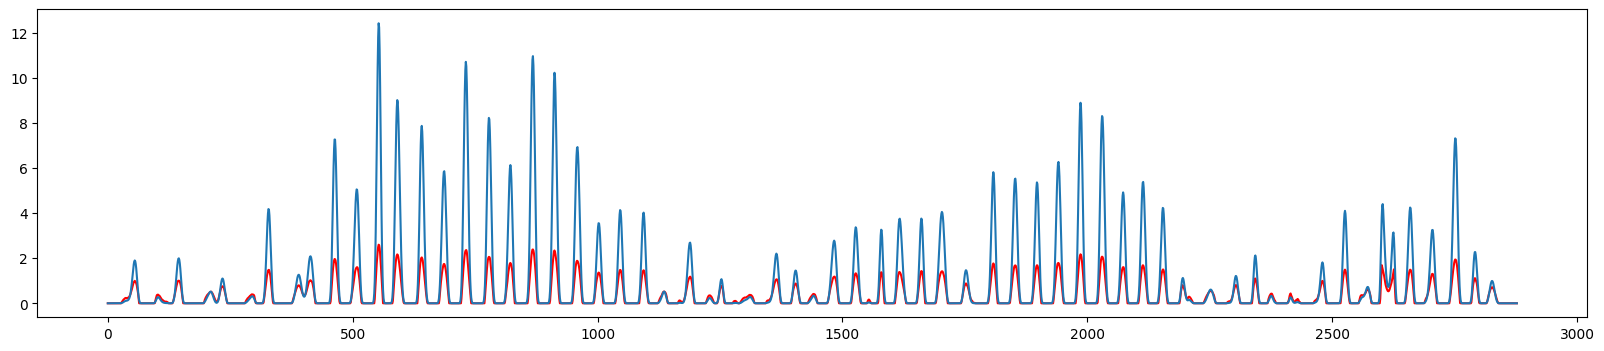

In [29]:
def min_max_normalize_1D(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

fig1 = plt.figure(figsize=(20, 4))

sig = onsets_y['left_hand']['sensor_abs_pos_filtered']
sig1 = onsets_y['left_hand']['sensor_abs']
sig1_energy = sig1**2

sig1_local = compute_local_energy(sig1.flatten(), window_type='hann', window_length=15)

plt.plot(sig1, color = 'red')
plt.plot(sig1_local*20)
# plt.plot(onsets_y['left_hand']['sensor_onsets'])
# plt.hlines(y=0.1, xmin=0, xmax=len(sig), color='r', linestyle='--', label="zero line")
plt.show()

In [11]:
sig1.shape

(2878, 1)

In [ ]:

# For y-axis plots:
bpm1 = bpms_y["left_hand"]
bpm2 = bpms_y["right_hand"]
bpm3 = bpms_y["left_foot"]
bpm4 = bpms_y["right_foot"]
bpm5 = bpms_y["both_hand"]
bpm6 = bpms_y["both_foot"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=100)
fig.suptitle(f"{filename}\nReference Tempo: {ref}\nBoth Hand Y: {bpm5}, \nBoth Foot Y: {bpm6}", fontsize=11)

# axes[0, 0].plot(onsets_y['left_hand']["sensor_abs_pos_filtered"], color='blue')
axes[0, 0].plot(onsets_y['left_hand']["sensor_onsets"] * max(onsets_y['left_hand']["sensor_abs_pos_filtered"]), 
                  color='black', linestyle='--')

axes[0, 0].plot(tempo_data['left_hand_y']['estimated_beat_pulse'])
axes[0, 0].set_title("Left Hand Y Onsets, BPM: " + str(bpm1))

# axes[0, 1].plot(onsets_y['right_hand']["sensor_abs_pos_filtered"], color='green')
axes[0, 1].plot(onsets_y['right_hand']["sensor_onsets"] * max(onsets_y['right_hand']["sensor_abs_pos_filtered"]), 
                  color='black', linestyle='--')
axes[0, 1].plot(tempo_data['right_hand_y']['estimated_beat_pulse'])
axes[0, 1].set_title("Right Hand Y Onsets, BPM: " + str(bpm2))

# axes[1, 0].plot(onsets_y['left_foot']["sensor_abs_pos_filtered"], color='red')
axes[1, 0].plot(onsets_y['left_foot']["sensor_onsets"] * max(onsets_y['left_foot']["sensor_abs_pos_filtered"]), 
                  color='black', linestyle='--')
axes[1, 0].plot(tempo_data['left_foot_y']['estimated_beat_pulse'])
axes[1, 0].set_title("Left Ankle Y Onsets, BPM: " + str(bpm3))

# axes[1, 1].plot(onsets_y['right_foot']["sensor_abs_pos_filtered"], color='purple')
axes[1, 1].plot(onsets_y['right_foot']["sensor_onsets"] * max(onsets_y['right_foot']["sensor_abs_pos_filtered"]), 
                  color='black', linestyle='--')
axes[1, 1].plot(tempo_data['right_foot_y']['estimated_beat_pulse'])
axes[1, 1].set_title("Right Ankle Y Onsets, BPM: " + str(bpm4))

# Optional common formatting for y-axis plots
for ax in axes.flat:
    ax.grid(True)
    ax.set_xlabel("Frame")
    ax.set_ylabel("Y Position")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# For x-axis plots:
bpm1_x = bpms_x["left_hand"]
bpm2_x = bpms_x["right_hand"]
bpm3_x = bpms_x["left_foot"]
bpm4_x = bpms_x["right_foot"]
bpm5_x = bpms_x["both_hand"]
bpm6_x = bpms_x["both_foot"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=100)
fig.suptitle(f"{filename}\nReference Tempo: {ref}\nBoth Hand X: {bpm5_x}, \nBoth Foot X: {bpm6_x}", fontsize=11)

axes[0, 0].plot(onsets_x['left_hand']["sensor_abs_pos_filtered"], color='blue')
axes[0, 0].plot(onsets_x['left_hand']["sensor_onsets"] * max(onsets_x['left_hand']["sensor_abs_pos_filtered"]), 
                  color='black', linestyle='--')
axes[0, 0].set_title("Left Hand X Onsets, BPM: " + str(bpm1_x))

axes[0, 1].plot(onsets_x['right_hand']["sensor_abs_pos_filtered"], color='green')
axes[0, 1].plot(onsets_x['right_hand']["sensor_onsets"] * max(onsets_x['right_hand']["sensor_abs_pos_filtered"]), 
                  color='black', linestyle='--')
axes[0, 1].set_title("Right Hand X Onsets, BPM: " + str(bpm2_x))

axes[1, 0].plot(onsets_x['left_foot']["sensor_abs_pos_filtered"], color='red')
axes[1, 0].plot(onsets_x['left_foot']["sensor_onsets"] * max(onsets_x['left_foot']["sensor_abs_pos_filtered"]), 
                  color='black', linestyle='--')
axes[1, 0].set_title("Left Ankle X Onsets, BPM: " + str(bpm3_x))

axes[1, 1].plot(onsets_x['right_foot']["sensor_abs_pos_filtered"], color='purple')
axes[1, 1].plot(onsets_x['right_foot']["sensor_onsets"] * max(onsets_x['right_foot']["sensor_abs_pos_filtered"]), 
                  color='black', linestyle='--')
axes[1, 1].set_title("Right Ankle X Onsets, BPM: " + str(bpm4_x))

# Optional common formatting for x-axis plots
for ax in axes.flat:
    ax.grid(True)
    ax.set_xlabel("Frame")
    ax.set_ylabel("X Position")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
###### Method 1 #######